# 1. FPM memory-time-accuracy analysis

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import os, sys
import argparse
import time
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import time

# MELD toolbox
import meld.recon as recon
from meld.recon import UnrolledNetwork

# import local experiment files
sys.path.append('../')
import dataloader
import visualizer
import model

In [3]:
# Setup device
device_no = 0
torch.cuda.set_device(device_no)
device = torch.device("cuda:"+str(device_no) if torch.cuda.is_available() else "cpu")

In [4]:
path = '/home/kellman/Workspace/PYTHON/Design_FPM_pytorch/datasets_train_iccp_results/train_amp_exp_n10000.mat' 
dataset = dataloader.dataloader(path, 100, 1, device)
metadata = dataset.getMetadata()
metadata['Np'] = dataset[0][0].shape[2:]
metadata['num_bf'] = 1
metadata['num_df'] = 10
metadata['num_unrolls'] = 100
metadata['alpha'] = 0.2
metadata['T'] = 4

memlimit = 11000

In [5]:
def setup_run(num_unrolls, meldFlag=False, cpList=None):
    metadata['num_unrolls'] = num_unrolls
    network = model.model(metadata, device=device)
    input_data, output_data = dataset[0]
    xtest = network.initialize(input_data[:1,...].to(device), device=device)
    trainable_network = UnrolledNetwork(network.network, 
                                        xtest, 
                                        memlimit=memlimit, 
                                        setupFlag = False,
                                        device=device)
    trainable_network.meldFlag = meldFlag
    if cpList is not None:
        trainable_network.cpList = cpList
    else:
        trainable_network.cpList = [-1]
        
    if trainable_network.meldFlag is False:
        trainable_network.cpList = [-1]
    return network, trainable_network
    


## Evaluate Time and Memory for standard backpropagation

In [6]:
Nunrolls = 5
unrollList = np.linspace(10,100, Nunrolls,dtype='int32')
print(unrollList)

# setup time and memory
timings1 = np.zeros(Nunrolls)
memory1 = np.zeros(Nunrolls)

# run experiment
for nn in range(Nunrolls):
    print('Number of unrolls: {0:d}'.format(unrollList[nn]))
    network, trainable_network = setup_run(unrollList[nn])
    
    # setup data
    input_data, output_data = dataset[0]
    x0 = network.initialize(input_data.to(device), device=device)
    
    # evaluate time
    start_time = time.time()
    torch.cuda.empty_cache()
    start_memory = torch.cuda.memory_cached(device)
    xN_tmp, loss_tmp, _, _ = trainable_network.forward(x0, output_data.to(device))
    end_time = time.time()
    end_memory = torch.cuda.memory_cached(device)
    
    timings1[nn] = end_time - start_time
    memory1[nn] = end_memory - start_memory


[ 10  32  55  77 100]
Number of unrolls: 10
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 32
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 55
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 77
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 100
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625


In [7]:
print(timings1)
print(memory1 / 1024**2)

[1.01107764 1.79283118 3.29658699 4.82177854 6.66958952]
[ 750. 2396. 4118. 5768. 7494.]


## Evaluate Time | Memory | Accuracy for reverse recalculation

In [8]:
# setup time and memory
timings2 = np.zeros(Nunrolls)
memory2 = np.zeros(Nunrolls)

# run experiment
for nn in range(Nunrolls):
    print('Number of unrolls: {0:d}'.format(unrollList[nn]))
    network, trainable_network = setup_run(unrollList[nn], meldFlag=True, cpList = [-1])
    
    # setup data
    input_data, output_data = dataset[0]
    x0 = network.initialize(input_data.to(device), device=device)
    
    # evaluate time
    start_time = time.time()
    torch.cuda.empty_cache()
    start_memory = torch.cuda.memory_cached(device)
    xN_tmp, loss_tmp, _, _ = trainable_network.forward(x0, output_data.to(device))
    end_time = time.time()
    end_memory = torch.cuda.memory_cached(device)
    
    timings2[nn] = end_time - start_time
    memory2[nn] = end_memory - start_memory

    
# setup accuracy
accuracy2 = np.zeros(Nunrolls)

# run experiment
for nn in range(Nunrolls):
    print('Number of unrolls: {0:d}'.format(unrollList[nn]))
    network, trainable_network = setup_run(unrollList[nn], meldFlag=True, cpList = [-1])
    
    # setup data
    input_data, output_data = dataset[0]
    x0 = network.initialize(input_data.to(device), device=device)
    
    # evaluate time
    xN_tmp, loss_tmp, Xf, Xb = trainable_network.forward(x0, output_data.to(device), interFlag=True)

    error = Xf - Xb
    accuracy2[nn] = np.mean(error.cpu().numpy())**2


Number of unrolls: 10
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 32
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 55
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 77
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 100
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 10
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 32
Reconstruction's pixel size (um): 0.414516129032258
S

In [9]:
print(timings2)
print(memory2 / 1024**2)
print(accuracy2)

[ 1.86918283  3.53663135  6.05386686  8.63719296 11.06071138]
[74. 78. 80. 80. 80.]
[1.01208459e-09 4.59702150e-09 1.01450364e-01 8.90870742e+02
 3.78238172e+12]


## Evaluate MELD linear checkpointing

In [10]:
timings3 = np.zeros(Nunrolls)
memory3 = np.zeros(Nunrolls)

# setup checkpoints
Ncp = 10
ckpts = [[it for it in range(0,N,Ncp)] for N in unrollList]
print(ckpts)

# run experiment
for nn in range(Nunrolls):
    print('Number of unrolls: {0:d}'.format(unrollList[nn]))
    print(ckpts[nn])
    network, trainable_network = setup_run(unrollList[nn], meldFlag=True, cpList = ckpts[nn])
    
    # setup data
    input_data, output_data = dataset[0]
    x0 = network.initialize(input_data.to(device), device=device)
    
    # evaluate time
    start_time = time.time()
    torch.cuda.empty_cache()
    start_memory = torch.cuda.memory_cached(device)
    xN_tmp, loss_tmp, _, _ = trainable_network.forward(x0, output_data.to(device))
    end_time = time.time()
    end_memory = torch.cuda.memory_cached(device)
    
    timings3[nn] = end_time - start_time
    memory3[nn] = end_memory - start_memory

    
# setup accuracy
accuracy3 = np.zeros(Nunrolls)

# run experiment
for nn in range(Nunrolls):
    print('Number of unrolls: {0:d}'.format(unrollList[nn]))
    print(ckpts[nn])

    network, trainable_network = setup_run(unrollList[nn], meldFlag=True, cpList = ckpts[nn])
    
    # setup data
    input_data, output_data = dataset[0]
    x0 = network.initialize(input_data.to(device), device=device)
    
    # evaluate time
    xN_tmp, loss_tmp, Xf, Xb = trainable_network.forward(x0, output_data.to(device), interFlag=True)

    error = Xf - Xb
    accuracy3[nn] = np.mean(error.cpu().numpy())**2


[[0], [0, 10, 20, 30], [0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50, 60, 70], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]]
Number of unrolls: 10
[0]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 32
[0, 10, 20, 30]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 55
[0, 10, 20, 30, 40, 50]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 77
[0, 10, 20, 30, 40, 50, 60, 70]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 100
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um

In [15]:
print(timings3)
print(memory3 / 1024**2)
print(accuracy3)

[ 1.11720347  3.309376    5.93343878  8.21979713 10.77563906]
[78. 78. 78. 78. 80.]
[1.01208459e-09 1.24379018e-10 4.22594051e-11 2.15852524e-11
 1.28054907e-11]


## Evaluate MELD exponential checkpointing

In [11]:
timings4 = np.zeros(Nunrolls)
memory4 = np.zeros(Nunrolls)

# setup checkpoints
Ncp = 15
tau = 25
ckpts = [[int(N*(1-np.exp(-t/tau))) for t in range(0,N,Ncp)] for N in unrollList]
print(ckpts)

# run experiment
for nn in range(Nunrolls):
    print('Number of unrolls: {0:d}'.format(unrollList[nn]))
    print(ckpts[nn])
    network, trainable_network = setup_run(unrollList[nn], meldFlag=True, cpList = ckpts[nn])
    
    # setup data
    input_data, output_data = dataset[0]
    x0 = network.initialize(input_data.to(device), device=device)
    
    # evaluate time
    start_time = time.time()
    torch.cuda.empty_cache()
    start_memory = torch.cuda.memory_cached(device)
    xN_tmp, loss_tmp, _, _ = trainable_network.forward(x0, output_data.to(device))
    end_time = time.time()
    end_memory = torch.cuda.memory_cached(device)
    
    timings4[nn] = end_time - start_time
    memory4[nn] = end_memory - start_memory

    
# setup accuracy
accuracy4 = np.zeros(Nunrolls)

# run experiment
for nn in range(Nunrolls):
    print('Number of unrolls: {0:d}'.format(unrollList[nn]))
    print(ckpts[nn])

    network, trainable_network = setup_run(unrollList[nn], meldFlag=True, cpList = ckpts[nn])
    
    # setup data
    input_data, output_data = dataset[0]
    x0 = network.initialize(input_data.to(device), device=device)
    
    # evaluate time
    xN_tmp, loss_tmp, Xf, Xb = trainable_network.forward(x0, output_data.to(device), interFlag=True)

    error = Xf - Xb
    accuracy4[nn] = np.mean(error.cpu().numpy())**2


[[0], [0, 14, 22], [0, 24, 38, 45], [0, 34, 53, 64, 70, 73], [0, 45, 69, 83, 90, 95, 97]]
Number of unrolls: 10
[0]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 32
[0, 14, 22]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 55
[0, 24, 38, 45]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 77
[0, 34, 53, 64, 70, 73]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 100
[0, 45, 69, 83, 90, 95, 97]
Reconstruction's pixel size (um): 0.414516129032258
System's pixel size limit (um): 1.285
Camera's effective pixel size (um): 1.625
Number of unrolls: 10
[0]
Reconstruction's pixel size (

In [12]:
print(timings4)
print(memory4 / 1024**2)
print(accuracy4)

[ 1.13468456  3.29435182  5.72816396  8.48133898 10.79009628]
[76. 78. 78. 80. 80.]
[1.01208459e-09 2.89461563e-10 4.36555057e-10 1.41074453e-09
 1.77746675e-05]


<IPython.core.display.Javascript object>


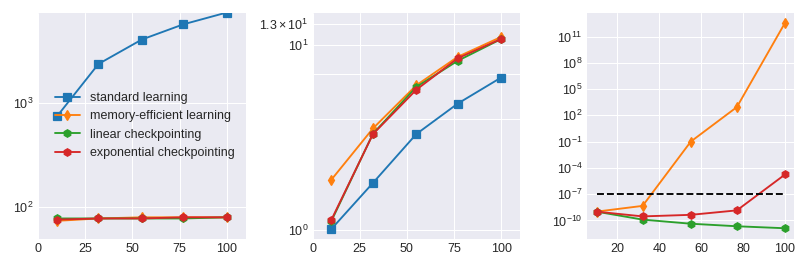

/home/kellman/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/kellman/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:1718: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  self.set_ylim([v[2], v[3]], emit=emit, auto=False)


In [13]:
plt.figure(figsize=(9,3))
plt.subplot(131)
factor = 1024**2
plt.semilogy(unrollList,memory1/factor,'C0s-',label='standard learning')
plt.semilogy(unrollList,memory2/factor,'C1d-',label='memory-efficient learning')
plt.semilogy(unrollList,memory3/factor,'C2h-',label='linear checkpointing')
plt.semilogy(unrollList,memory4/factor,'C3h-',label='exponential checkpointing')
# plt.title('Memory')
# plt.xlabel('# of unrolled iterations')
# plt.ylabel('MB')
# plt.yticks(np.arange(100, 2000, 400))\
plt.axis([0, 110, 50, 7500])
# plt.yticks(np.arange(50, 7500, 1000))
plt.grid('on')
plt.legend()


plt.subplot(132)
plt.semilogy(unrollList,timings1,'C0s-',label='standard learning')
plt.semilogy(unrollList,timings2,'C1d-',label='memory-efficient learning')
plt.semilogy(unrollList,timings3,'C2h-',label='linear checkpointing')
plt.semilogy(unrollList,timings4,'C3h-',label='exponential checkpointing')
plt.axis([0, 110, 0, 15])
plt.yticks(np.arange(1, 15, 3))
plt.grid('on')

# plt.title('Time')
# plt.xlabel('# of unrolled iterations')
# plt.ylabel('Seconds')

plt.subplot(133)
plt.semilogy(unrollList,accuracy2,'C1d-',label='memory-efficient learning')
plt.semilogy(unrollList,accuracy3,'C2h-',label='linear checkpointing')
plt.semilogy(unrollList,accuracy4,'C3h-',label='exponential checkpointing')

eps = np.finfo(np.float32).eps * np.ones(len(unrollList))
plt.semilogy(unrollList,eps,'k--',label='Mach. Eps.')

plt.grid('on')

# plt.title('Accuracy')
# plt.xlabel('# of unrolled iterations')
# plt.ylabel('MSE')

plt.tight_layout()
plt.savefig('./memory-time-accuracy-fpm.pdf',dpi=300)


<IPython.core.display.Javascript object>


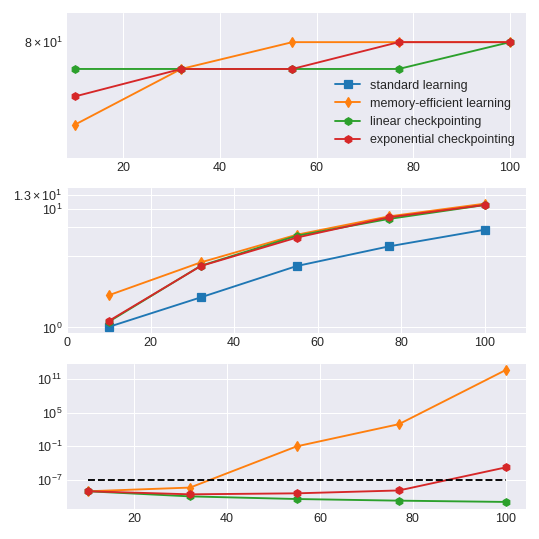

In [14]:
plt.figure(figsize=(6,6))
plt.subplot(311)
factor = 1024**2
plt.semilogy(unrollList,memory1/factor,'C0s-',label='standard learning')
plt.semilogy(unrollList,memory2/factor,'C1d-',label='memory-efficient learning')
plt.semilogy(unrollList,memory3/factor,'C2h-',label='linear checkpointing')
plt.semilogy(unrollList,memory4/factor,'C3h-',label='exponential checkpointing')
# plt.title('Memory')
# plt.xlabel('# of unrolled iterations')
# plt.ylabel('MB')
# plt.yticks(np.arange(100, 2000, 400))\
plt.axis([0, 110, 50, 7500])
# plt.yticks(np.arange(50, 7500, 1000))
plt.grid('on')
plt.legend()


plt.subplot(312)
plt.semilogy(unrollList,timings1,'C0s-',label='standard learning')
plt.semilogy(unrollList,timings2,'C1d-',label='memory-efficient learning')
plt.semilogy(unrollList,timings3,'C2h-',label='linear checkpointing')
plt.semilogy(unrollList,timings4,'C3h-',label='exponential checkpointing')
plt.axis([0, 110, 0, 15])
plt.yticks(np.arange(1, 15, 3))
plt.grid('on')

# plt.title('Time')
# plt.xlabel('# of unrolled iterations')
# plt.ylabel('Seconds')

plt.subplot(313)
plt.semilogy(unrollList,accuracy2,'C1d-',label='memory-efficient learning')
plt.semilogy(unrollList,accuracy3,'C2h-',label='linear checkpointing')
plt.semilogy(unrollList,accuracy4,'C3h-',label='exponential checkpointing')

eps = np.finfo(np.float32).eps * np.ones(len(unrollList))
plt.semilogy(unrollList,eps,'k--',label='Mach. Eps.')

plt.grid('on')

# plt.title('Accuracy')
# plt.xlabel('# of unrolled iterations')
# plt.ylabel('MSE')

plt.tight_layout()
plt.savefig('./memory-time-accuracy-fpm.pdf',dpi=300)
